In [ ]:
!pip install matplotlib

In [1]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [ ]:
class Sampling(tf.keras.layers.Layer):
    @tf.function
    def call(self, inputs, training=False):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
LR_SCHEDULE = [
    (25, 0.0001),
    (50, 0.00005),
    (75, 0.00002),
    (100, 0.00001),
]

def lr_schedule(epoch, lr):
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [ ]:
class CustomAAECallbacks(tf.keras.callbacks.Callback):
    def __init__(self, X, schedule, patience=0):
        super(CustomAAECallbacks, self).__init__()
        # Immagini per la ricostruzione
        self.X = X
        self.patience = patience
        self.schedule = schedule

    def on_train_begin(self, logs=None):
        self.wait = 0
        self.stopped_epoch = 0
        self.ae_best = np.Inf
        self.gen_best = np.Inf
        self.dc_best = np.Inf

    def on_epoch_begin(self, epoch, logs=None):
        ae_lr = float(tf.keras.backend.get_value(self.model.ae_optimizer.learning_rate))
        gen_lr = float(tf.keras.backend.get_value(self.model.gen_optimizer.learning_rate))
        dc_lr = float(tf.keras.backend.get_value(self.model.dc_optimizer.learning_rate))
        scheduled_ae_lr = self.schedule(epoch, ae_lr)
        scheduled_dc_lr = self.schedule(epoch, dc_lr)
        scheduled_gen_lr = self.schedule(epoch, gen_lr)
        tf.keras.backend.set_value(self.model.ae_optimizer.lr, scheduled_ae_lr)
        tf.keras.backend.set_value(self.model.gen_optimizer.lr, scheduled_gen_lr)
        tf.keras.backend.set_value(self.model.dc_optimizer.lr, scheduled_dc_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_ae_lr))

    def on_epoch_end(self, epoch, logs=None):
        # Save 10 reconstructions every 10 epochs
        if epoch%10==0:
            self.model.save_10_reconstructions(self.X, epoch)

        current_ae_loss = logs.get("val_ae_loss")
        current_gen_loss = logs.get("val_gen_loss")
        current_dc_loss = logs.get("val_dc_loss")
        if np.less(current_ae_loss, self.ae_best) or np.less(current_gen_loss, self.gen_best) or np.less(current_dc_loss, self.dc_best):
            self.ae_best = current_ae_loss
            self.dc_best = current_dc_loss
            self.gen_best = current_gen_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))


In [ ]:
def get_encoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    flatten = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2')(flatten)
    x = tf.keras.layers.BatchNormalization()(x)
    z_mean = tf.keras.layers.Dense(latent_dim)(x)
    z_log_var = tf.keras.layers.Dense(latent_dim)(x)

    z = Sampling()([z_mean, z_log_var])

    model = tf.keras.Model(inputs, z, name="Encoder")
    return model

def get_decoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, stride_reduction):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/stride_reduction**2), activation='relu', kernel_regularizer='l2')(x)
    
    reshaped = tf.keras.layers.Reshape((int(input_shape[0]/stride_reduction), int(input_shape[1]/stride_reduction), filters[3]))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2')(reshaped)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    x = tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(leaky_alpha)(x)

    image = tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same', kernel_regularizer='l2')(x)

    model = tf.keras.Model(inputs, image, name="Decoder")
    return model

def get_discriminator(latent_dim, discriminator_units):
    inputs = tf.keras.Input(shape=(latent_dim,))

    x = tf.keras.layers.Dense(discriminator_units[0], activation='relu', kernel_regularizer='l2')(inputs)
    x = tf.keras.layers.Dense(discriminator_units[1], activation='relu', kernel_regularizer='l2')(x)

    vote = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs, vote, name="Discriminator")
    return model


    

In [ ]:
class AAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, base_lr, max_lr, step_size, gen_coef, batch_size):
        super(AAE, self).__init__()

        self.batch_size = batch_size
        # Calculate the stride factor of downsampling
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        
        # Latent dimension
        self.latent_dim = latent_dim
        # Define losses and accuracies
        self.mse = tf.keras.losses.MeanSquaredError()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        # Define the learning rates for cyclic learning rate (not used)
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.gen_coef = gen_coef

        # Encoder Net
        self.encoder = get_encoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units)

        # Decoder Net
        self.decoder = get_decoder(input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, self.stride_reduction)

        # Discriminator Net
        self.discriminator = get_discriminator(latent_dim, discriminator_units)

    def compile(self, ae_opt, dc_opt, gen_opt):
        super(AAE, self).compile()
        # Set optimizers
        self.ae_optimizer = ae_opt
        self.gen_optimizer = gen_opt
        self.dc_optimizer = dc_opt
        # Set loss functions
        self.ae_loss_fn = tf.keras.losses.MeanSquaredError()
        self.binCe_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Set metrics and accuracies
        self.dc_acc_fn = tf.keras.metrics.BinaryAccuracy(name='dc_accuracy')
        self.ae_metrics = tf.keras.metrics.MeanSquaredError(name='ae_loss')
        self.dc_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='dc_loss')
        self.gen_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='gen_loss')
        # Compile internal models
        self.encoder.compile()
        self.decoder.compile()
        self.discriminator.compile()

    # Define the metrics
    @property
    def metrics(self):
        return [self.dc_acc_fn, self.ae_metrics, self.dc_metrics, self.gen_metrics]

    # Encoding function
    def encode(self, x, training=False):
        return self.encoder(x, training=training)

    # Decoding function
    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    # Save 10 reconstructions
    def save_10_reconstructions(self, X, epoch):
        fig, ax = plt.subplots(2,5,figsize=(15,5))
        images = X[:10,:,:,:].reshape((10,32,32,3))
        z = self.encode(images)
        image_reconstruction = self.decode(z, apply_sigmoid=True).numpy()
        for i in range(10):
            ax.ravel()[i].imshow(image_reconstruction[i,:])
            ax.ravel()[i].axis(False)
        fig.savefig(f'reconstructed_epoch_{epoch+1:03d}.png',bbox_inches='tight')

    @tf.function
    def test_step(self, batch_x):
        generated_noise = tf.random.normal([self.batch_size, self.latent_dim], mean=0.0, stddev=1.0)
        z_generated = self.encode(batch_x)
        X_reconstructed = self.decode(z_generated, apply_sigmoid=True)
                
        dc_fake = self.discriminator(z_generated)
        dc_real = self.discriminator(generated_noise)

        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        return {m.name: m.result() for m in self.metrics}


    # Function for the train step
    @tf.function
    def train_step(self, batch_x):
        # Autoencoder training
        with tf.GradientTape() as ae_tape:
            z_generated = self.encode(batch_x, training=True)
            X_reconstructed = self.decode(z_generated, apply_sigmoid=True, training=True)
            ae_loss = self.ae_loss_fn(batch_x, X_reconstructed)

        # Apply the gradients
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        # Discriminator training with normal prior
        generated_noise = tf.random.normal([self.batch_size, self.latent_dim], mean=0.0, stddev=1.0)
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)

            real_loss = self.binCe_loss_fn(tf.ones_like(dc_real), dc_real)
            fake_loss = self.binCe_loss_fn(tf.zeros_like(dc_fake), dc_fake)
            dc_loss = real_loss + fake_loss

            dc_acc = self.dc_acc_fn(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        # Apply the gradients
        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator training (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            gen_loss = self.binCe_loss_fn(tf.ones_like(dc_fake),dc_fake)

        # Apply the gradients
        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        # Update the metrics
        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], axis=0), tf.concat([dc_fake, dc_real], axis=0))
        return {m.name: m.result() for m in self.metrics}
    



In [ ]:
base_lr = 0.0001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 149

latent_dim = 256
alpha_leaky = 0.2
filters = [64,128,256,512]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [1000,300]
discriminator_units = [200, 200]
keep_prob = 0.5
gen_coef = 1.5

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, base_lr, max_lr, step_size, gen_coef, batch_size)
aae.compile(tf.keras.optimizers.Adam(learning_rate = base_lr), tf.keras.optimizers.Adam(learning_rate=base_lr), tf.keras.optimizers.Adam(learning_rate=base_lr*gen_coef))

In [ ]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard('logs', histogram_freq=1)
customAAECallback = CustomAAECallbacks(X=test_images[:10], schedule=lr_schedule, patience=10)

Epoch 1/149

Epoch 00000: Learning rate is 0.0001.


2022-03-01 10:40:26.697370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2022-03-01 10:40:30.224658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


391/391 - 134s - dc_accuracy: 0.4444 - ae_loss: 0.0293 - dc_loss: 3.0477 - gen_loss: 257.7361 - val_dc_accuracy: 0.4858 - val_ae_loss: 0.0625 - val_dc_loss: 0.9183 - val_gen_loss: 1.4877


Epoch 2/149

Epoch 00001: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4924 - ae_loss: 0.0153 - dc_loss: 0.7300 - gen_loss: 1.3684 - val_dc_accuracy: 0.4954 - val_ae_loss: 0.0606 - val_dc_loss: 0.6563 - val_gen_loss: 1.4152


Epoch 3/149

Epoch 00002: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5047 - ae_loss: 0.0121 - dc_loss: 0.6457 - gen_loss: 1.2509 - val_dc_accuracy: 0.5135 - val_ae_loss: 0.0531 - val_dc_loss: 0.6272 - val_gen_loss: 1.1810


Epoch 4/149

Epoch 00003: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5219 - ae_loss: 0.0101 - dc_loss: 0.6668 - gen_loss: 1.0188 - val_dc_accuracy: 0.5558 - val_ae_loss: 0.0311 - val_dc_loss: 0.5963 - val_gen_loss: 1.1369


Epoch 5/149

Epoch 00004: Learning rate is 0.0001.


391/391 - 124s - dc_accuracy: 0.5320 - ae_loss: 0.0089 - dc_loss: 0.7086 - gen_loss: 0.8357 - val_dc_accuracy: 0.5461 - val_ae_loss: 0.0123 - val_dc_loss: 0.6911 - val_gen_loss: 0.9469


Epoch 6/149

Epoch 00005: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4994 - ae_loss: 0.0081 - dc_loss: 0.8295 - gen_loss: 0.5683 - val_dc_accuracy: 0.6079 - val_ae_loss: 0.0082 - val_dc_loss: 0.6759 - val_gen_loss: 0.9405


Epoch 7/149

Epoch 00006: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4847 - ae_loss: 0.0076 - dc_loss: 0.9253 - gen_loss: 0.4490 - val_dc_accuracy: 0.5536 - val_ae_loss: 0.0081 - val_dc_loss: 0.7556 - val_gen_loss: 0.7670


Epoch 8/149

Epoch 00007: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4662 - ae_loss: 0.0072 - dc_loss: 0.9747 - gen_loss: 0.4070 - val_dc_accuracy: 0.6570 - val_ae_loss: 0.0103 - val_dc_loss: 0.7058 - val_gen_loss: 0.9087


Epoch 9/149

Epoch 00008: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4654 - ae_loss: 0.0068 - dc_loss: 1.1153 - gen_loss: 0.2858 - val_dc_accuracy: 0.4493 - val_ae_loss: 0.0071 - val_dc_loss: 0.9295 - val_gen_loss: 0.5381


Epoch 10/149

Epoch 00009: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4489 - ae_loss: 0.0066 - dc_loss: 1.0745 - gen_loss: 0.3124 - val_dc_accuracy: 0.7689 - val_ae_loss: 0.0073 - val_dc_loss: 0.5325 - val_gen_loss: 1.0997


Epoch 11/149

Epoch 00010: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5174 - ae_loss: 0.0063 - dc_loss: 1.1744 - gen_loss: 0.2484 - val_dc_accuracy: 0.7363 - val_ae_loss: 0.0074 - val_dc_loss: 0.6176 - val_gen_loss: 0.8664


Epoch 12/149

Epoch 00011: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5252 - ae_loss: 0.0061 - dc_loss: 1.2478 - gen_loss: 0.2348 - val_dc_accuracy: 0.7694 - val_ae_loss: 0.0063 - val_dc_loss: 0.5094 - val_gen_loss: 1.3840


Epoch 13/149

Epoch 00012: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5224 - ae_loss: 0.0059 - dc_loss: 1.3134 - gen_loss: 0.1826 - val_dc_accuracy: 0.7154 - val_ae_loss: 0.0060 - val_dc_loss: 0.6457 - val_gen_loss: 0.7873


Epoch 14/149

Epoch 00013: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4842 - ae_loss: 0.0057 - dc_loss: 1.3805 - gen_loss: 0.1576 - val_dc_accuracy: 0.7574 - val_ae_loss: 0.0059 - val_dc_loss: 0.5850 - val_gen_loss: 0.9977


Epoch 15/149

Epoch 00014: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4140 - ae_loss: 0.0056 - dc_loss: 1.2279 - gen_loss: 0.2267 - val_dc_accuracy: 0.5662 - val_ae_loss: 0.0061 - val_dc_loss: 0.7989 - val_gen_loss: 0.6768


Epoch 16/149

Epoch 00015: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.3799 - ae_loss: 0.0054 - dc_loss: 1.1510 - gen_loss: 0.2636 - val_dc_accuracy: 0.6228 - val_ae_loss: 0.0059 - val_dc_loss: 0.7529 - val_gen_loss: 0.7108


Epoch 17/149

Epoch 00016: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4667 - ae_loss: 0.0053 - dc_loss: 1.2316 - gen_loss: 0.2071 - val_dc_accuracy: 0.6767 - val_ae_loss: 0.0057 - val_dc_loss: 0.6504 - val_gen_loss: 0.8316


Epoch 18/149

Epoch 00017: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4018 - ae_loss: 0.0052 - dc_loss: 1.0695 - gen_loss: 0.3079 - val_dc_accuracy: 0.2981 - val_ae_loss: 0.0069 - val_dc_loss: 0.9501 - val_gen_loss: 0.4541


Epoch 19/149

Epoch 00018: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4243 - ae_loss: 0.0052 - dc_loss: 1.0062 - gen_loss: 0.3973 - val_dc_accuracy: 0.7178 - val_ae_loss: 0.0067 - val_dc_loss: 0.5602 - val_gen_loss: 1.0426


Epoch 20/149

Epoch 00019: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4478 - ae_loss: 0.0050 - dc_loss: 1.1121 - gen_loss: 0.2884 - val_dc_accuracy: 0.6285 - val_ae_loss: 0.0062 - val_dc_loss: 0.7116 - val_gen_loss: 0.7791


Epoch 21/149

Epoch 00020: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4448 - ae_loss: 0.0049 - dc_loss: 1.0003 - gen_loss: 0.3698 - val_dc_accuracy: 0.6694 - val_ae_loss: 0.0051 - val_dc_loss: 0.7047 - val_gen_loss: 0.7457


Epoch 22/149

Epoch 00021: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.3865 - ae_loss: 0.0048 - dc_loss: 1.0548 - gen_loss: 0.3108 - val_dc_accuracy: 0.5915 - val_ae_loss: 0.0052 - val_dc_loss: 0.7223 - val_gen_loss: 0.5911


Epoch 23/149

Epoch 00022: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.3884 - ae_loss: 0.0047 - dc_loss: 1.0755 - gen_loss: 0.2894 - val_dc_accuracy: 0.4722 - val_ae_loss: 0.0055 - val_dc_loss: 0.8056 - val_gen_loss: 0.5617


Epoch 24/149

Epoch 00023: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4022 - ae_loss: 0.0047 - dc_loss: 0.9318 - gen_loss: 0.4023 - val_dc_accuracy: 0.7687 - val_ae_loss: 0.0050 - val_dc_loss: 0.5666 - val_gen_loss: 0.8167


Epoch 25/149

Epoch 00024: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4219 - ae_loss: 0.0046 - dc_loss: 1.0098 - gen_loss: 0.3680 - val_dc_accuracy: 0.8002 - val_ae_loss: 0.0058 - val_dc_loss: 0.3970 - val_gen_loss: 1.5409


Epoch 26/149

Epoch 00025: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4904 - ae_loss: 0.0045 - dc_loss: 1.0958 - gen_loss: 0.3090 - val_dc_accuracy: 0.7052 - val_ae_loss: 0.0052 - val_dc_loss: 0.6097 - val_gen_loss: 0.8946


Epoch 27/149

Epoch 00026: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4850 - ae_loss: 0.0044 - dc_loss: 1.0970 - gen_loss: 0.2817 - val_dc_accuracy: 0.6408 - val_ae_loss: 0.0044 - val_dc_loss: 0.7320 - val_gen_loss: 0.5873


Epoch 28/149

Epoch 00027: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4278 - ae_loss: 0.0043 - dc_loss: 1.0917 - gen_loss: 0.2949 - val_dc_accuracy: 0.5182 - val_ae_loss: 0.0049 - val_dc_loss: 0.8102 - val_gen_loss: 0.6274


Epoch 29/149

Epoch 00028: Learning rate is 0.0001.


391/391 - 130s - dc_accuracy: 0.4490 - ae_loss: 0.0043 - dc_loss: 0.8952 - gen_loss: 0.4378 - val_dc_accuracy: 0.5932 - val_ae_loss: 0.0048 - val_dc_loss: 0.7165 - val_gen_loss: 0.6957


Epoch 30/149

Epoch 00029: Learning rate is 0.0001.


391/391 - 124s - dc_accuracy: 0.4446 - ae_loss: 0.0042 - dc_loss: 1.0309 - gen_loss: 0.3323 - val_dc_accuracy: 0.5132 - val_ae_loss: 0.0052 - val_dc_loss: 0.8020 - val_gen_loss: 0.8692


Epoch 31/149

Epoch 00030: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4765 - ae_loss: 0.0041 - dc_loss: 1.0339 - gen_loss: 0.3190 - val_dc_accuracy: 0.5266 - val_ae_loss: 0.0041 - val_dc_loss: 0.7460 - val_gen_loss: 0.6566


Epoch 32/149

Epoch 00031: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4243 - ae_loss: 0.0041 - dc_loss: 0.9487 - gen_loss: 0.3850 - val_dc_accuracy: 0.5827 - val_ae_loss: 0.0043 - val_dc_loss: 0.6862 - val_gen_loss: 0.7567


Epoch 33/149

Epoch 00032: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4758 - ae_loss: 0.0041 - dc_loss: 1.0250 - gen_loss: 0.3397 - val_dc_accuracy: 0.5541 - val_ae_loss: 0.0047 - val_dc_loss: 0.7384 - val_gen_loss: 0.9120


Epoch 34/149

Epoch 00033: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4396 - ae_loss: 0.0040 - dc_loss: 0.8837 - gen_loss: 0.4514 - val_dc_accuracy: 0.5762 - val_ae_loss: 0.0042 - val_dc_loss: 0.7205 - val_gen_loss: 0.6433


Epoch 35/149

Epoch 00034: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4916 - ae_loss: 0.0039 - dc_loss: 0.8029 - gen_loss: 0.5337 - val_dc_accuracy: 0.6640 - val_ae_loss: 0.0044 - val_dc_loss: 0.6534 - val_gen_loss: 0.6700


Epoch 36/149

Epoch 00035: Learning rate is 0.0001.


391/391 - 124s - dc_accuracy: 0.4881 - ae_loss: 0.0039 - dc_loss: 0.8133 - gen_loss: 0.5526 - val_dc_accuracy: 0.5379 - val_ae_loss: 0.0042 - val_dc_loss: 0.7000 - val_gen_loss: 0.8047


Epoch 37/149

Epoch 00036: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4750 - ae_loss: 0.0039 - dc_loss: 0.8184 - gen_loss: 0.5259 - val_dc_accuracy: 0.5439 - val_ae_loss: 0.0043 - val_dc_loss: 0.7256 - val_gen_loss: 0.6752


Epoch 38/149

Epoch 00037: Learning rate is 0.0001.


391/391 - 130s - dc_accuracy: 0.4956 - ae_loss: 0.0039 - dc_loss: 0.8071 - gen_loss: 0.5587 - val_dc_accuracy: 0.5542 - val_ae_loss: 0.0038 - val_dc_loss: 0.7421 - val_gen_loss: 0.6600


Epoch 39/149

Epoch 00038: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5246 - ae_loss: 0.0038 - dc_loss: 0.7777 - gen_loss: 0.5948 - val_dc_accuracy: 0.5200 - val_ae_loss: 0.0041 - val_dc_loss: 0.7696 - val_gen_loss: 0.7675


Epoch 40/149

Epoch 00039: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4495 - ae_loss: 0.0038 - dc_loss: 0.8909 - gen_loss: 0.4460 - val_dc_accuracy: 0.6071 - val_ae_loss: 0.0046 - val_dc_loss: 0.6772 - val_gen_loss: 0.7206


Epoch 41/149

Epoch 00040: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5117 - ae_loss: 0.0038 - dc_loss: 0.8385 - gen_loss: 0.5699 - val_dc_accuracy: 0.5598 - val_ae_loss: 0.0045 - val_dc_loss: 0.7241 - val_gen_loss: 0.8254


Epoch 42/149

Epoch 00041: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4986 - ae_loss: 0.0037 - dc_loss: 0.8298 - gen_loss: 0.5467 - val_dc_accuracy: 0.5216 - val_ae_loss: 0.0040 - val_dc_loss: 0.7295 - val_gen_loss: 0.8228


Epoch 43/149

Epoch 00042: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5084 - ae_loss: 0.0037 - dc_loss: 0.7872 - gen_loss: 0.5964 - val_dc_accuracy: 0.5218 - val_ae_loss: 0.0039 - val_dc_loss: 0.7082 - val_gen_loss: 0.7082


Epoch 44/149

Epoch 00043: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5122 - ae_loss: 0.0036 - dc_loss: 0.7561 - gen_loss: 0.6027 - val_dc_accuracy: 0.5236 - val_ae_loss: 0.0037 - val_dc_loss: 0.7212 - val_gen_loss: 0.6643


Epoch 45/149

Epoch 00044: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4893 - ae_loss: 0.0036 - dc_loss: 0.7671 - gen_loss: 0.5704 - val_dc_accuracy: 0.5141 - val_ae_loss: 0.0039 - val_dc_loss: 0.6997 - val_gen_loss: 0.7120


Epoch 46/149

Epoch 00045: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4969 - ae_loss: 0.0036 - dc_loss: 0.8103 - gen_loss: 0.5446 - val_dc_accuracy: 0.6278 - val_ae_loss: 0.0045 - val_dc_loss: 0.6850 - val_gen_loss: 0.7599


Epoch 47/149

Epoch 00046: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5137 - ae_loss: 0.0037 - dc_loss: 0.8797 - gen_loss: 0.5187 - val_dc_accuracy: 0.5509 - val_ae_loss: 0.0044 - val_dc_loss: 0.7211 - val_gen_loss: 0.9605


Epoch 48/149

Epoch 00047: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4682 - ae_loss: 0.0036 - dc_loss: 0.8455 - gen_loss: 0.5308 - val_dc_accuracy: 0.4961 - val_ae_loss: 0.0039 - val_dc_loss: 0.7638 - val_gen_loss: 0.6352


Epoch 49/149

Epoch 00048: Learning rate is 0.0001.


391/391 - 130s - dc_accuracy: 0.4488 - ae_loss: 0.0035 - dc_loss: 0.7923 - gen_loss: 0.5359 - val_dc_accuracy: 0.5033 - val_ae_loss: 0.0038 - val_dc_loss: 0.7463 - val_gen_loss: 0.7188


Epoch 50/149

Epoch 00049: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.5119 - ae_loss: 0.0035 - dc_loss: 0.7745 - gen_loss: 0.5731 - val_dc_accuracy: 0.5278 - val_ae_loss: 0.0038 - val_dc_loss: 0.6923 - val_gen_loss: 0.6672


Epoch 51/149

Epoch 00050: Learning rate is 0.0001.


391/391 - 125s - dc_accuracy: 0.4803 - ae_loss: 0.0033 - dc_loss: 0.7582 - gen_loss: 0.5831 - val_dc_accuracy: 0.5071 - val_ae_loss: 0.0031 - val_dc_loss: 0.7179 - val_gen_loss: 0.6056


Epoch 52/149

Epoch 00051: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4884 - ae_loss: 0.0033 - dc_loss: 0.7398 - gen_loss: 0.5649 - val_dc_accuracy: 0.4975 - val_ae_loss: 0.0032 - val_dc_loss: 0.7149 - val_gen_loss: 0.6361


Epoch 53/149

Epoch 00052: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0033 - dc_loss: 0.7249 - gen_loss: 0.6213 - val_dc_accuracy: 0.4976 - val_ae_loss: 0.0033 - val_dc_loss: 0.7151 - val_gen_loss: 0.6235


Epoch 54/149

Epoch 00053: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4907 - ae_loss: 0.0033 - dc_loss: 0.7301 - gen_loss: 0.6093 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7220 - val_gen_loss: 0.6644


Epoch 55/149

Epoch 00054: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.5000 - ae_loss: 0.0033 - dc_loss: 0.7115 - gen_loss: 0.6416 - val_dc_accuracy: 0.4973 - val_ae_loss: 0.0033 - val_dc_loss: 0.6808 - val_gen_loss: 0.7718


Epoch 56/149

Epoch 00055: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4907 - ae_loss: 0.0033 - dc_loss: 0.7438 - gen_loss: 0.6154 - val_dc_accuracy: 0.4973 - val_ae_loss: 0.0033 - val_dc_loss: 0.7063 - val_gen_loss: 0.7050


Epoch 57/149

Epoch 00056: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4983 - ae_loss: 0.0033 - dc_loss: 0.7320 - gen_loss: 0.6643 - val_dc_accuracy: 0.4975 - val_ae_loss: 0.0034 - val_dc_loss: 0.6777 - val_gen_loss: 0.7053


Epoch 58/149

Epoch 00057: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4947 - ae_loss: 0.0033 - dc_loss: 0.7354 - gen_loss: 0.6176 - val_dc_accuracy: 0.5008 - val_ae_loss: 0.0033 - val_dc_loss: 0.7004 - val_gen_loss: 0.6742


Epoch 59/149

Epoch 00058: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4980 - ae_loss: 0.0034 - dc_loss: 0.7403 - gen_loss: 0.6242 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0034 - val_dc_loss: 0.7336 - val_gen_loss: 0.7390


Epoch 60/149

Epoch 00059: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4898 - ae_loss: 0.0033 - dc_loss: 0.7329 - gen_loss: 0.6174 - val_dc_accuracy: 0.4971 - val_ae_loss: 0.0034 - val_dc_loss: 0.7303 - val_gen_loss: 0.6126


Epoch 61/149

Epoch 00060: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4986 - ae_loss: 0.0033 - dc_loss: 0.7200 - gen_loss: 0.6302 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0037 - val_dc_loss: 0.6845 - val_gen_loss: 0.7711


Epoch 62/149

Epoch 00061: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4900 - ae_loss: 0.0034 - dc_loss: 0.7675 - gen_loss: 0.6220 - val_dc_accuracy: 0.4974 - val_ae_loss: 0.0039 - val_dc_loss: 0.7378 - val_gen_loss: 0.6724


Epoch 63/149

Epoch 00062: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4950 - ae_loss: 0.0035 - dc_loss: 0.7585 - gen_loss: 0.6165 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0038 - val_dc_loss: 0.7229 - val_gen_loss: 0.6769


Epoch 64/149

Epoch 00063: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4928 - ae_loss: 0.0035 - dc_loss: 0.7518 - gen_loss: 0.6116 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0036 - val_dc_loss: 0.7184 - val_gen_loss: 0.6973


Epoch 65/149

Epoch 00064: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4896 - ae_loss: 0.0035 - dc_loss: 0.7491 - gen_loss: 0.6048 - val_dc_accuracy: 0.4980 - val_ae_loss: 0.0037 - val_dc_loss: 0.6729 - val_gen_loss: 0.6506


Epoch 66/149

Epoch 00065: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4907 - ae_loss: 0.0035 - dc_loss: 0.7577 - gen_loss: 0.5914 - val_dc_accuracy: 0.4819 - val_ae_loss: 0.0040 - val_dc_loss: 0.6891 - val_gen_loss: 0.6753


Epoch 67/149

Epoch 00066: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4947 - ae_loss: 0.0035 - dc_loss: 0.7436 - gen_loss: 0.6189 - val_dc_accuracy: 0.4774 - val_ae_loss: 0.0037 - val_dc_loss: 0.7299 - val_gen_loss: 0.5982


Epoch 68/149

Epoch 00067: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4951 - ae_loss: 0.0035 - dc_loss: 0.7446 - gen_loss: 0.6135 - val_dc_accuracy: 0.4951 - val_ae_loss: 0.0036 - val_dc_loss: 0.7496 - val_gen_loss: 0.5797


Epoch 69/149

Epoch 00068: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4943 - ae_loss: 0.0035 - dc_loss: 0.7442 - gen_loss: 0.6058 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0038 - val_dc_loss: 0.6834 - val_gen_loss: 0.7365


Epoch 70/149

Epoch 00069: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4926 - ae_loss: 0.0035 - dc_loss: 0.7625 - gen_loss: 0.6083 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0043 - val_dc_loss: 0.7524 - val_gen_loss: 0.6602


Epoch 71/149

Epoch 00070: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4907 - ae_loss: 0.0037 - dc_loss: 0.8076 - gen_loss: 0.5855 - val_dc_accuracy: 0.4985 - val_ae_loss: 0.0044 - val_dc_loss: 0.7520 - val_gen_loss: 0.6707


Epoch 72/149

Epoch 00071: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4843 - ae_loss: 0.0037 - dc_loss: 0.7902 - gen_loss: 0.5646 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0041 - val_dc_loss: 0.7216 - val_gen_loss: 0.6215


Epoch 73/149

Epoch 00072: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4962 - ae_loss: 0.0036 - dc_loss: 0.7540 - gen_loss: 0.5805 - val_dc_accuracy: 0.4878 - val_ae_loss: 0.0042 - val_dc_loss: 0.6638 - val_gen_loss: 0.7010


Epoch 74/149

Epoch 00073: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4928 - ae_loss: 0.0036 - dc_loss: 0.7771 - gen_loss: 0.5817 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0051 - val_dc_loss: 0.6587 - val_gen_loss: 1.0539


Epoch 75/149

Epoch 00074: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4912 - ae_loss: 0.0037 - dc_loss: 0.7764 - gen_loss: 0.5871 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0043 - val_dc_loss: 0.7077 - val_gen_loss: 0.6681


Epoch 76/149

Epoch 00075: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0035 - dc_loss: 0.7350 - gen_loss: 0.5752 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7182 - val_gen_loss: 0.5911


Epoch 77/149

Epoch 00076: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0034 - dc_loss: 0.7189 - gen_loss: 0.5977 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7103 - val_gen_loss: 0.5923


Epoch 78/149

Epoch 00077: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7101 - gen_loss: 0.5947 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7017 - val_gen_loss: 0.6219


Epoch 79/149

Epoch 00078: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4958 - ae_loss: 0.0033 - dc_loss: 0.7189 - gen_loss: 0.6075 - val_dc_accuracy: 0.4361 - val_ae_loss: 0.0037 - val_dc_loss: 0.7284 - val_gen_loss: 0.5379


Epoch 80/149

Epoch 00079: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4960 - ae_loss: 0.0035 - dc_loss: 0.7190 - gen_loss: 0.6098 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7140 - val_gen_loss: 0.6144


Epoch 81/149

Epoch 00080: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0034 - dc_loss: 0.7133 - gen_loss: 0.6195 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0034 - val_dc_loss: 0.6936 - val_gen_loss: 0.6594


Epoch 82/149

Epoch 00081: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0034 - dc_loss: 0.7119 - gen_loss: 0.6201 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0036 - val_dc_loss: 0.6958 - val_gen_loss: 0.6864


Epoch 83/149

Epoch 00082: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4996 - ae_loss: 0.0035 - dc_loss: 0.7233 - gen_loss: 0.6169 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0037 - val_dc_loss: 0.6964 - val_gen_loss: 0.6466


Epoch 84/149

Epoch 00083: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4990 - ae_loss: 0.0035 - dc_loss: 0.7188 - gen_loss: 0.6370 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0034 - val_dc_loss: 0.6983 - val_gen_loss: 0.6375


Epoch 85/149

Epoch 00084: Learning rate is 0.0000.


391/391 - 124s - dc_accuracy: 0.4998 - ae_loss: 0.0034 - dc_loss: 0.7121 - gen_loss: 0.6281 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0038 - val_dc_loss: 0.6925 - val_gen_loss: 0.6599


Epoch 86/149

Epoch 00085: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4960 - ae_loss: 0.0035 - dc_loss: 0.7210 - gen_loss: 0.6396 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0039 - val_dc_loss: 0.6871 - val_gen_loss: 0.6838


Epoch 87/149

Epoch 00086: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4945 - ae_loss: 0.0034 - dc_loss: 0.7144 - gen_loss: 0.6219 - val_dc_accuracy: 0.4837 - val_ae_loss: 0.0041 - val_dc_loss: 0.6896 - val_gen_loss: 0.6432


Epoch 88/149

Epoch 00087: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4896 - ae_loss: 0.0036 - dc_loss: 0.7304 - gen_loss: 0.6571 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0041 - val_dc_loss: 0.6422 - val_gen_loss: 0.8197


Epoch 89/149

Epoch 00088: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4996 - ae_loss: 0.0035 - dc_loss: 0.7207 - gen_loss: 0.6317 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.6775 - val_gen_loss: 0.7180


Epoch 90/149

Epoch 00089: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4990 - ae_loss: 0.0035 - dc_loss: 0.7240 - gen_loss: 0.6248 - val_dc_accuracy: 0.4956 - val_ae_loss: 0.0038 - val_dc_loss: 0.7127 - val_gen_loss: 0.6182


Epoch 91/149

Epoch 00090: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4995 - ae_loss: 0.0035 - dc_loss: 0.7168 - gen_loss: 0.6351 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0038 - val_dc_loss: 0.6998 - val_gen_loss: 0.6542


Epoch 92/149

Epoch 00091: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4848 - ae_loss: 0.0036 - dc_loss: 0.7291 - gen_loss: 0.6550 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.6911 - val_gen_loss: 0.6268


Epoch 93/149

Epoch 00092: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4821 - ae_loss: 0.0036 - dc_loss: 0.7319 - gen_loss: 0.6152 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0037 - val_dc_loss: 0.7172 - val_gen_loss: 0.6115


Epoch 94/149

Epoch 00093: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0034 - dc_loss: 0.7152 - gen_loss: 0.6424 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0036 - val_dc_loss: 0.6846 - val_gen_loss: 0.7127


Epoch 95/149

Epoch 00094: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4993 - ae_loss: 0.0035 - dc_loss: 0.7154 - gen_loss: 0.6182 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0045 - val_dc_loss: 0.6394 - val_gen_loss: 0.8840


Epoch 96/149

Epoch 00095: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4906 - ae_loss: 0.0036 - dc_loss: 0.7377 - gen_loss: 0.6640 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.7137 - val_gen_loss: 0.6947


Epoch 97/149

Epoch 00096: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4972 - ae_loss: 0.0034 - dc_loss: 0.7145 - gen_loss: 0.6207 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7121 - val_gen_loss: 0.6197


Epoch 98/149

Epoch 00097: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0034 - dc_loss: 0.7083 - gen_loss: 0.6313 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7053 - val_gen_loss: 0.6319


Epoch 99/149

Epoch 00098: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0034 - dc_loss: 0.7136 - gen_loss: 0.6553 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0036 - val_dc_loss: 0.7154 - val_gen_loss: 0.7102


Epoch 100/149

Epoch 00099: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4697 - ae_loss: 0.0035 - dc_loss: 0.7366 - gen_loss: 0.6088 - val_dc_accuracy: 0.4761 - val_ae_loss: 0.0054 - val_dc_loss: 0.7115 - val_gen_loss: 0.5794


Epoch 101/149

Epoch 00100: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4943 - ae_loss: 0.0034 - dc_loss: 0.7257 - gen_loss: 0.6764 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7056 - val_gen_loss: 0.6256


Epoch 102/149

Epoch 00101: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4965 - ae_loss: 0.0035 - dc_loss: 0.7147 - gen_loss: 0.6248 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0038 - val_dc_loss: 0.7096 - val_gen_loss: 0.6811


Epoch 103/149

Epoch 00102: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4997 - ae_loss: 0.0035 - dc_loss: 0.7080 - gen_loss: 0.6274 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.7044 - val_gen_loss: 0.6772


Epoch 104/149

Epoch 00103: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7080 - gen_loss: 0.6302 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7030 - val_gen_loss: 0.6371


Epoch 105/149

Epoch 00104: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7018 - gen_loss: 0.6379 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0030 - val_dc_loss: 0.7003 - val_gen_loss: 0.6397


Epoch 106/149

Epoch 00105: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7005 - gen_loss: 0.6418 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.6951 - val_gen_loss: 0.6674


Epoch 107/149

Epoch 00106: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7004 - gen_loss: 0.6360 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.6919 - val_gen_loss: 0.6506


Epoch 108/149

Epoch 00107: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4988 - ae_loss: 0.0034 - dc_loss: 0.7078 - gen_loss: 0.6549 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0036 - val_dc_loss: 0.6851 - val_gen_loss: 0.6697


Epoch 109/149

Epoch 00108: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4993 - ae_loss: 0.0033 - dc_loss: 0.7058 - gen_loss: 0.6490 - val_dc_accuracy: 0.4940 - val_ae_loss: 0.0035 - val_dc_loss: 0.6861 - val_gen_loss: 0.6075


Epoch 110/149

Epoch 00109: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4920 - ae_loss: 0.0033 - dc_loss: 0.7106 - gen_loss: 0.6552 - val_dc_accuracy: 0.4966 - val_ae_loss: 0.0032 - val_dc_loss: 0.7082 - val_gen_loss: 0.5969


Epoch 111/149

Epoch 00110: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7008 - gen_loss: 0.6449 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.6914 - val_gen_loss: 0.7255


Epoch 112/149

Epoch 00111: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4996 - ae_loss: 0.0033 - dc_loss: 0.7029 - gen_loss: 0.6504 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0045 - val_dc_loss: 0.6252 - val_gen_loss: 0.9463


Epoch 113/149

Epoch 00112: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4944 - ae_loss: 0.0033 - dc_loss: 0.7138 - gen_loss: 0.6513 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0043 - val_dc_loss: 0.6432 - val_gen_loss: 0.9012


Epoch 114/149

Epoch 00113: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7141 - gen_loss: 0.6518 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7029 - val_gen_loss: 0.6569


Epoch 115/149

Epoch 00114: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7025 - gen_loss: 0.6469 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.6978 - val_gen_loss: 0.6513


Epoch 116/149

Epoch 00115: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7013 - gen_loss: 0.6594 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6993 - val_gen_loss: 0.6506


Epoch 117/149

Epoch 00116: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.6993 - gen_loss: 0.6596 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.7047 - val_gen_loss: 0.6348


Epoch 118/149

Epoch 00117: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4991 - ae_loss: 0.0034 - dc_loss: 0.7070 - gen_loss: 0.6589 - val_dc_accuracy: 0.4914 - val_ae_loss: 0.0037 - val_dc_loss: 0.6892 - val_gen_loss: 0.6358


Epoch 119/149

Epoch 00118: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4934 - ae_loss: 0.0034 - dc_loss: 0.7180 - gen_loss: 0.6650 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.7085 - val_gen_loss: 0.6102


Epoch 120/149

Epoch 00119: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7020 - gen_loss: 0.6499 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.6995 - val_gen_loss: 0.6641


Epoch 121/149

Epoch 00120: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7001 - gen_loss: 0.6560 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0030 - val_dc_loss: 0.6981 - val_gen_loss: 0.6632


Epoch 122/149

Epoch 00121: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.6998 - gen_loss: 0.6528 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6957 - val_gen_loss: 0.6703


Epoch 123/149

Epoch 00122: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4766 - ae_loss: 0.0034 - dc_loss: 0.7144 - gen_loss: 0.6627 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0076 - val_dc_loss: 0.5753 - val_gen_loss: 1.2902


Epoch 124/149

Epoch 00123: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4988 - ae_loss: 0.0033 - dc_loss: 0.7241 - gen_loss: 0.6511 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0034 - val_dc_loss: 0.7024 - val_gen_loss: 0.6464


Epoch 125/149

Epoch 00124: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7093 - gen_loss: 0.6838 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0036 - val_dc_loss: 0.7043 - val_gen_loss: 0.6181


Epoch 126/149

Epoch 00125: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7039 - gen_loss: 0.6541 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7006 - val_gen_loss: 0.6342


Epoch 127/149

Epoch 00126: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7073 - gen_loss: 0.6732 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0037 - val_dc_loss: 0.7045 - val_gen_loss: 0.6393


Epoch 128/149

Epoch 00127: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4984 - ae_loss: 0.0033 - dc_loss: 0.7064 - gen_loss: 0.6516 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6999 - val_gen_loss: 0.6429


Epoch 129/149

Epoch 00128: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7015 - gen_loss: 0.6643 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6986 - val_gen_loss: 0.6799


Epoch 130/149

Epoch 00129: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0033 - dc_loss: 0.7085 - gen_loss: 0.6691 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.6931 - val_gen_loss: 0.6796


Epoch 131/149

Epoch 00130: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0033 - dc_loss: 0.7091 - gen_loss: 0.6615 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.7150 - val_gen_loss: 0.6725


Epoch 132/149

Epoch 00131: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4966 - ae_loss: 0.0033 - dc_loss: 0.7171 - gen_loss: 0.6601 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0030 - val_dc_loss: 0.7095 - val_gen_loss: 0.6706


Epoch 133/149

Epoch 00132: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7069 - gen_loss: 0.6455 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.7079 - val_gen_loss: 0.6674


Epoch 134/149

Epoch 00133: Learning rate is 0.0000.


391/391 - 130s - dc_accuracy: 0.4997 - ae_loss: 0.0034 - dc_loss: 0.7035 - gen_loss: 0.6491 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0040 - val_dc_loss: 0.6552 - val_gen_loss: 0.8296


Epoch 135/149

Epoch 00134: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7165 - gen_loss: 0.6758 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6975 - val_gen_loss: 0.6459


Epoch 136/149

Epoch 00135: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7035 - gen_loss: 0.6545 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7003 - val_gen_loss: 0.6380


Epoch 137/149

Epoch 00136: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4996 - ae_loss: 0.0032 - dc_loss: 0.7025 - gen_loss: 0.6681 - val_dc_accuracy: 0.4940 - val_ae_loss: 0.0039 - val_dc_loss: 0.6920 - val_gen_loss: 0.6333


Epoch 138/149

Epoch 00137: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4916 - ae_loss: 0.0033 - dc_loss: 0.7093 - gen_loss: 0.6529 - val_dc_accuracy: 0.4600 - val_ae_loss: 0.0040 - val_dc_loss: 0.6871 - val_gen_loss: 0.6427


Epoch 139/149

Epoch 00138: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4969 - ae_loss: 0.0032 - dc_loss: 0.7099 - gen_loss: 0.6717 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0038 - val_dc_loss: 0.7008 - val_gen_loss: 0.6151


Epoch 140/149

Epoch 00139: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4992 - ae_loss: 0.0032 - dc_loss: 0.7101 - gen_loss: 0.6733 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0031 - val_dc_loss: 0.7111 - val_gen_loss: 0.6528


Epoch 141/149

Epoch 00140: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7059 - gen_loss: 0.6461 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0035 - val_dc_loss: 0.6942 - val_gen_loss: 0.7197


Epoch 142/149

Epoch 00141: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4922 - ae_loss: 0.0033 - dc_loss: 0.7069 - gen_loss: 0.6614 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0041 - val_dc_loss: 0.6469 - val_gen_loss: 0.9362


Epoch 143/149

Epoch 00142: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4956 - ae_loss: 0.0032 - dc_loss: 0.7153 - gen_loss: 0.6589 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0037 - val_dc_loss: 0.6908 - val_gen_loss: 0.6730


Epoch 144/149

Epoch 00143: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4997 - ae_loss: 0.0032 - dc_loss: 0.7093 - gen_loss: 0.6592 - val_dc_accuracy: 0.4970 - val_ae_loss: 0.0033 - val_dc_loss: 0.6976 - val_gen_loss: 0.6400


Epoch 145/149

Epoch 00144: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4995 - ae_loss: 0.0032 - dc_loss: 0.7179 - gen_loss: 0.6915 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6981 - val_gen_loss: 0.6402


Epoch 146/149

Epoch 00145: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0032 - dc_loss: 0.7037 - gen_loss: 0.6542 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0030 - val_dc_loss: 0.7033 - val_gen_loss: 0.6549


Epoch 147/149

Epoch 00146: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0031 - dc_loss: 0.7011 - gen_loss: 0.6591 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0032 - val_dc_loss: 0.6921 - val_gen_loss: 0.7364


Epoch 148/149

Epoch 00147: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4981 - ae_loss: 0.0033 - dc_loss: 0.7092 - gen_loss: 0.6567 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0034 - val_dc_loss: 0.7039 - val_gen_loss: 0.6835


Epoch 149/149

Epoch 00148: Learning rate is 0.0000.


391/391 - 125s - dc_accuracy: 0.4998 - ae_loss: 0.0033 - dc_loss: 0.7001 - gen_loss: 0.6660 - val_dc_accuracy: 0.4972 - val_ae_loss: 0.0033 - val_dc_loss: 0.6936 - val_gen_loss: 0.6487


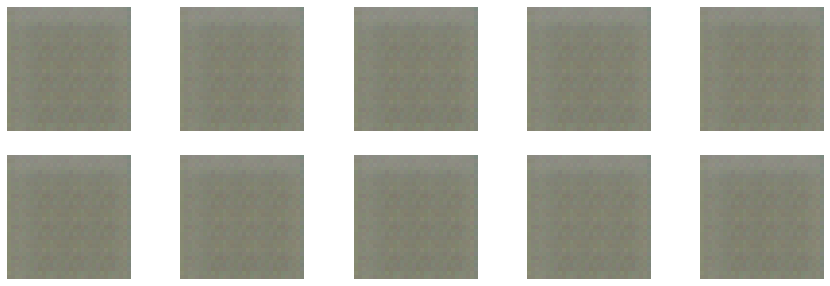

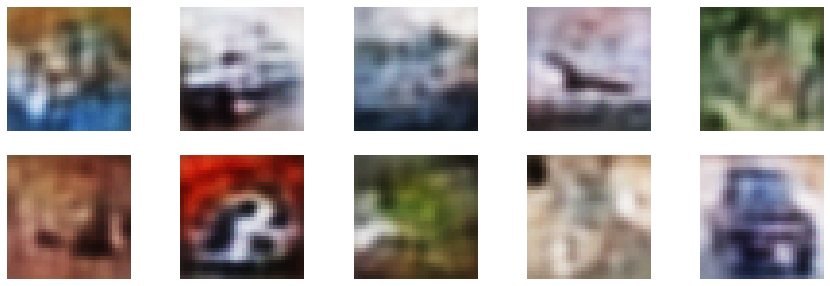

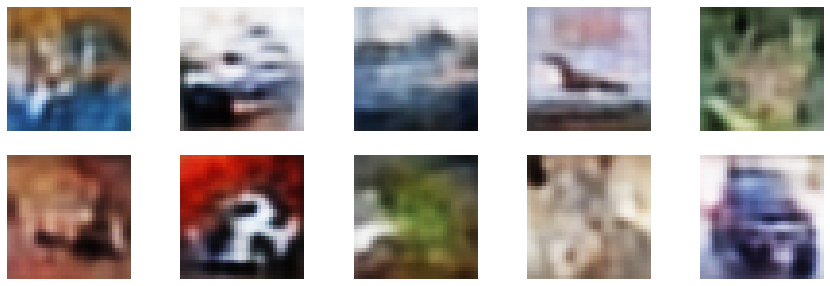

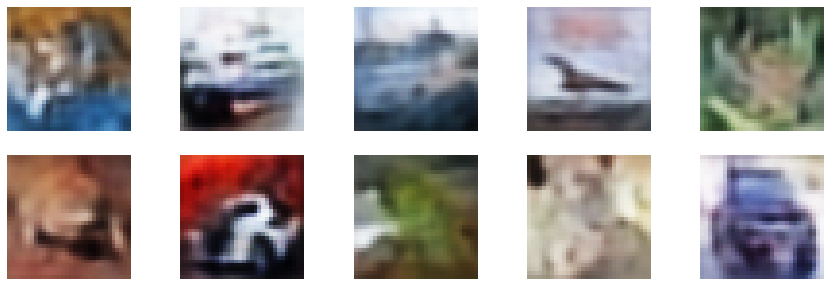

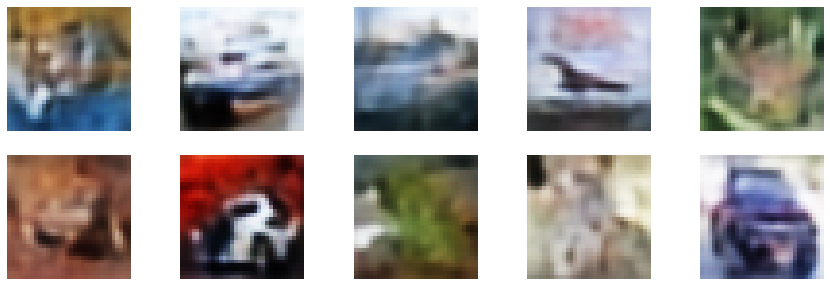

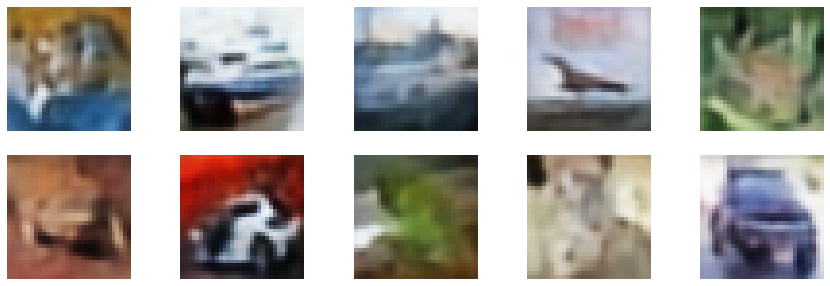

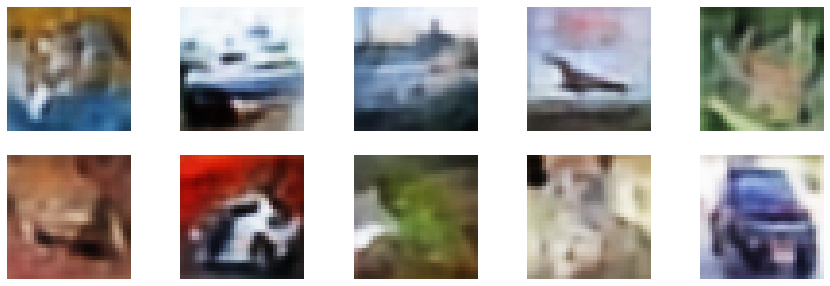

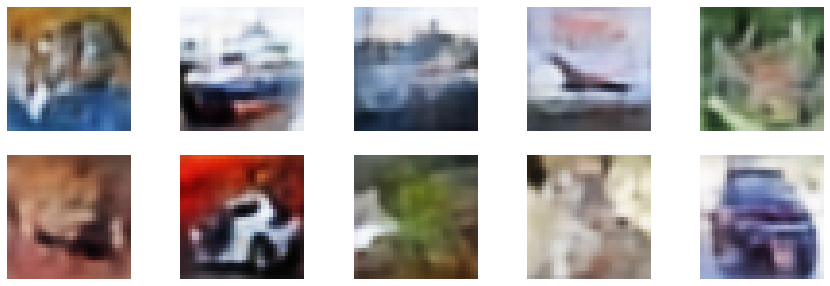

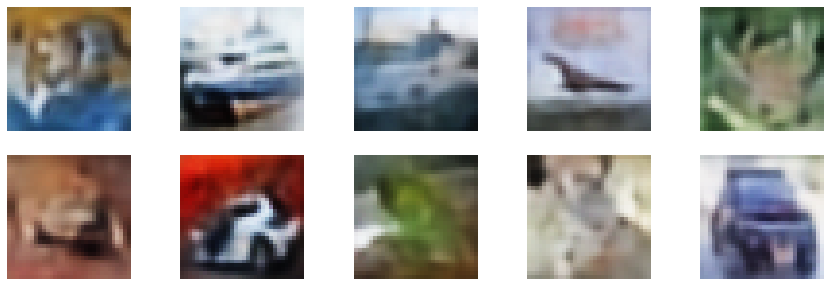

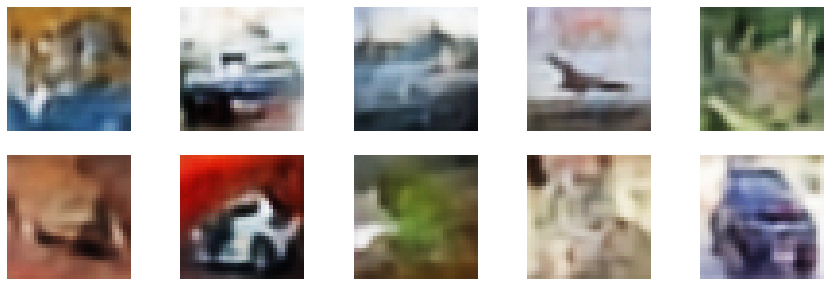

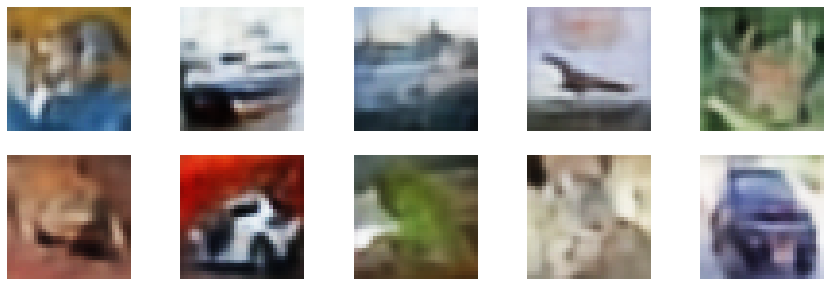

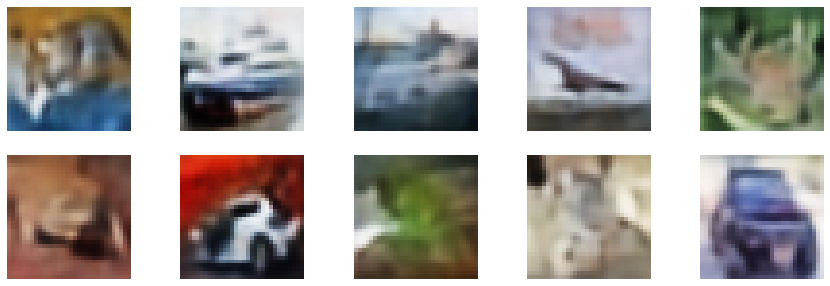

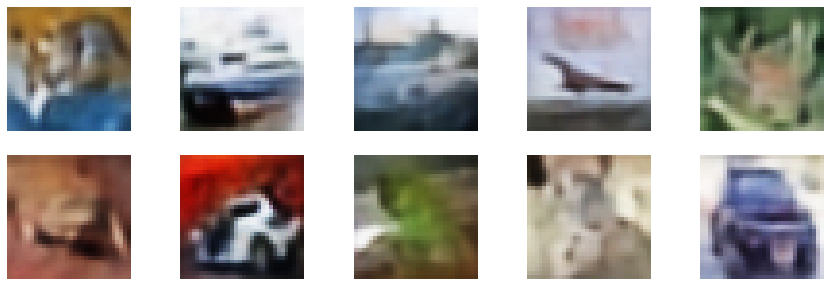

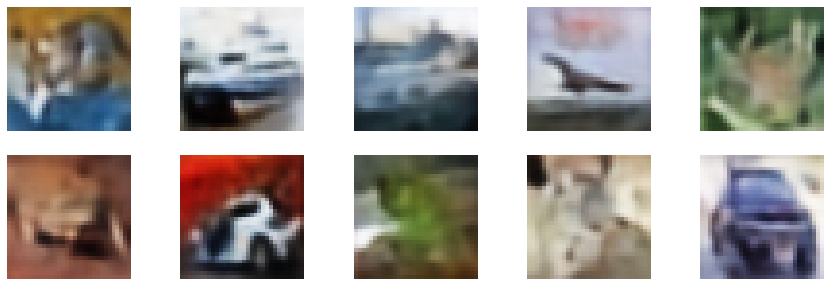

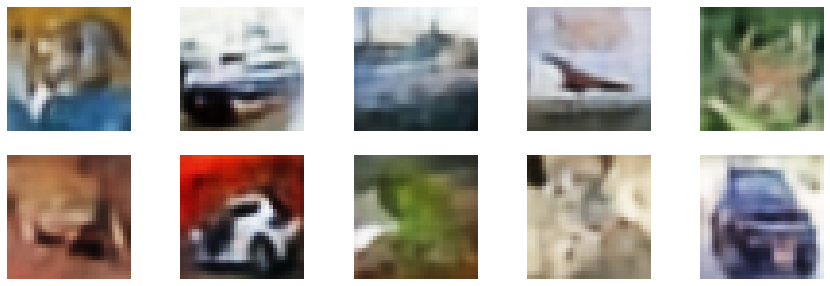

In [ ]:
history = aae.fit(x=train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[customAAECallback], verbose=2)

In [ ]:
aae.encoder.save('enc_model')
aae.decoder.save('dec_model')
aae.discriminator.save('dc_model')

2022-03-01 16:00:08.983430: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: enc_model/assets


INFO:tensorflow:Assets written to: dec_model/assets


INFO:tensorflow:Assets written to: dc_model/assets


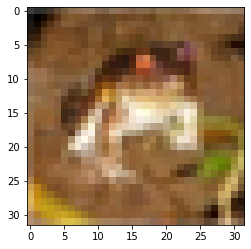

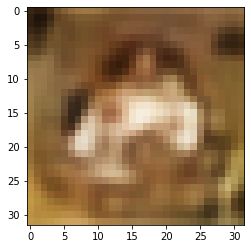

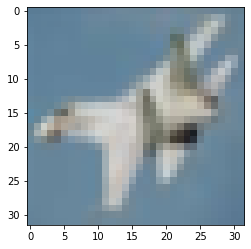

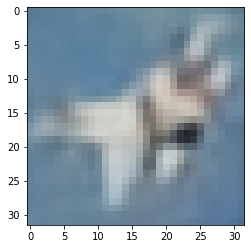

In [ ]:
image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

image = test_images[10,:,:,:].reshape((1,32,32,3))
z = aae.encode(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

In [ ]:
test_dc_accuracy, test_ae_loss, test_dc_loss, test_gen_loss = aae.evaluate(test_dataset, verbose=2)

79/79 - 6s - dc_accuracy: 0.4972 - ae_loss: 0.0033 - dc_loss: 0.6935 - gen_loss: 0.6487


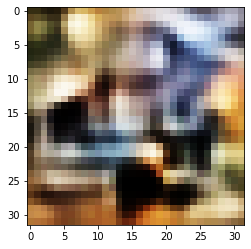

tf.Tensor([[0.067745]], shape=(1, 1), dtype=float32)


In [ ]:
z = np.random.randn(1,latent_dim)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
print(aae.discriminator(z))

In [ ]:
np.save('my_history.npy',history.history)

In [10]:
history = np.load('my_history.npy', allow_pickle='TRUE').item()

In [17]:
def plot_train_history(history):
    ae_loss = history['ae_loss']
    gen_loss = history['gen_loss']
    dc_loss = history['dc_loss']
    dc_accuracy = history['dc_accuracy']

    F, ax = plt.subplots(2,2,figsize=(15,15))
    ax[0, 0].plot(np.arange(len(ae_loss))+1, ae_loss, label='training')
    ax[0, 0].set_title('Autoencoder loss')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_ylabel('MSE')
    ax[0, 1].plot(np.arange(len(gen_loss))+1, gen_loss, label='training')
    ax[0, 1].set_title('Generator loss')
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].set_ylabel('BinCE')
    ax[1, 0].plot(np.arange(len(dc_loss))+1, dc_loss, label='training')
    ax[1, 0].set_title('Discriminator loss')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('BinCE')
    ax[1, 1].plot(np.arange(len(dc_accuracy))+1, dc_accuracy, label='training')
    ax[1, 1].set_title('Discriminator accuracy')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Correct votes')

    ae_loss = history['val_ae_loss']
    gen_loss = history['val_gen_loss']
    dc_loss = history['val_dc_loss']
    dc_accuracy = history['val_dc_accuracy']
    ax[0, 0].plot(np.arange(len(ae_loss))+1, ae_loss, label='validation')
    ax[0, 0].legend()
    ax[0, 1].plot(np.arange(len(gen_loss))+1, gen_loss, label='validation')
    ax[0, 1].legend()
    ax[0, 1].set_yscale('log')
    ax[1, 0].plot(np.arange(len(dc_loss))+1, dc_loss, label='validation')
    ax[1, 0].legend()
    ax[1, 1].plot(np.arange(len(dc_accuracy))+1, dc_accuracy, label='validation')
    ax[1, 1].legend()
    plt.show()

def plot_validation_history(history):
    ae_loss = history.history['val_ae_loss']
    gen_loss = history.history['val_gen_loss']
    dc_loss = history.history['val_dc_loss']
    dc_accuracy = history.history['val_dc_accuracy']

    F, ax = plt.subplots(2,2,figsize=(20,20))
    ax[0, 0].plot(np.arange(len(ae_loss))+1, ae_loss)
    ax[0, 0].set_title('Val Autoencoder loss')
    ax[0, 0].set_xlabel('Epochs')
    ax[0, 0].set_ylabel('MSE')
    ax[0, 1].plot(np.arange(len(gen_loss))+1, gen_loss)
    ax[0, 1].set_title('Val Generator loss')
    ax[0, 1].set_xlabel('Epochs')
    ax[0, 1].set_ylabel('BinCE')
    ax[1, 0].plot(np.arange(len(dc_loss))+1, dc_loss)
    ax[1, 0].set_title('Val Discriminator loss')
    ax[1, 0].set_xlabel('Epochs')
    ax[1, 0].set_ylabel('BinCE')
    ax[1, 1].plot(np.arange(len(dc_accuracy))+1, dc_accuracy)
    ax[1, 1].set_title('Val Discriminator accuracy')
    ax[1, 1].set_xlabel('Epochs')
    ax[1, 1].set_ylabel('Correct votes')
    plt.show()

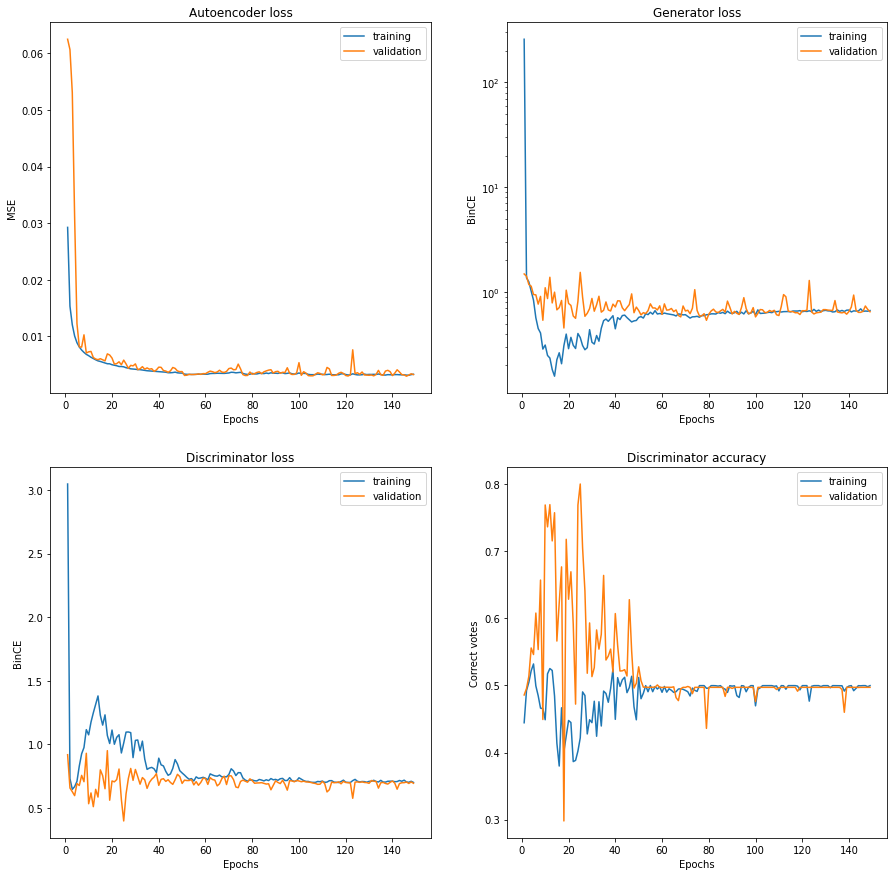

In [18]:
plot_train_history(history)

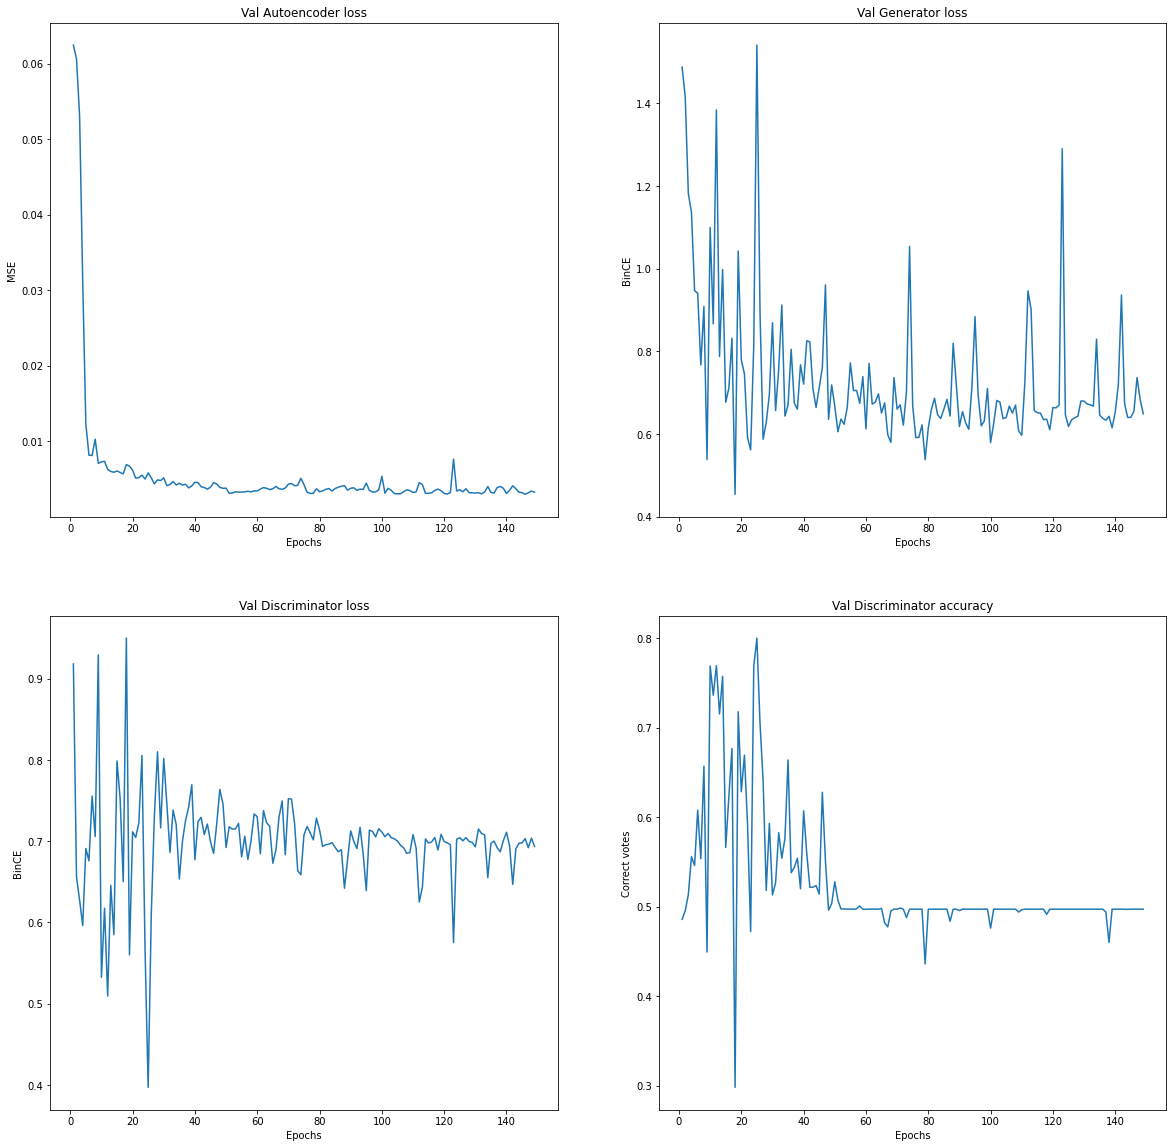

In [ ]:
plot_validation_history(history)

In [ ]:
def plot_latent(aae, data, labels):
    latent_data = aae.encode(data)
    plt.scatter(latent_data[:,0], latent_data[:,1], c=labels)

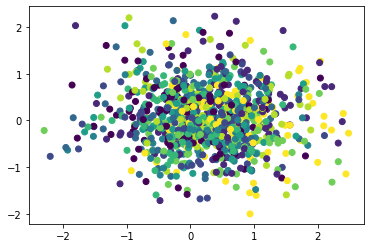

In [ ]:
plot_latent(aae, train_images[0:1000], train_labels[0:1000].reshape((1000)))